In [2]:
%matplotlib inline
from __future__ import print_function, division, absolute_import, unicode_literals

import os
import numpy as np
from collections import OrderedDict
from astropy.io import fits
from abc_util.masking import lensing_cuts
from sexcat_util.catalog_loader import combine_forced_photo_catalogs
from plot_util import tile_diagnostics, utils
from plot_util.corner_plot import corner_plot_multi_data

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('ticks')

/Users/joergherbel/Library/Python/2.7/lib/python/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
import ufig.config.DES0441_4414_lum_fct_blue_red as config
path_des = '/Users/joergherbel/projects/ufig_multi_band/DES0441-4414/'
path_ufig = './'
lenspectr_cfg_kwargs = dict(psf_p11_map=os.path.join(config.maps_remote_dir, 'psf/Y1A1r.maps.nside2048.psf_q11.fits'), 
                            psf_p12_map=os.path.join(config.maps_remote_dir, 'psf/Y1A1r.maps.nside2048.psf_q12.fits'), 
                            psf_p22_map=os.path.join(config.maps_remote_dir, 'psf/Y1A1r.maps.nside2048.psf_q22.fits'))

In [4]:
paths_des_im = OrderedDict(zip(config.filters, 
                               [os.path.join(path_des, config.tile_name+'_{}.fits'.format(f)) for f in 
                                config.filters]))
paths_ufig_im = OrderedDict(zip(config.filters, 
                                [os.path.join(path_ufig, config.tile_name+'_{}.fits'.format(f)) for f in 
                                 config.filters]))

In [5]:
paths_des_cat = OrderedDict(zip(config.filters, 
                                [os.path.join(path_des, config.tile_name+'_{}_forced_photo.sexcat'.format(f)) for f in 
                                 config.filters]))
paths_ufig_cat = OrderedDict(zip(config.filters, 
                                [os.path.join(path_ufig, config.tile_name+'_{}_forced_photo.sexcat'.format(f)) for f in 
                                 config.filters]))

In [6]:
des_mags = combine_forced_photo_catalogs(paths_des_cat, 
                                         'MAG_AUTO', 
                                         star_gal_sep=('r', 0))
ufig_mags = combine_forced_photo_catalogs(paths_ufig_cat, 
                                          'MAG_AUTO', 
                                          star_gal_sep=('r', 0))

des_r50 = combine_forced_photo_catalogs(paths_des_cat, 
                                        'FLUX_RADIUS', 
                                        star_gal_sep=('r', 0))
ufig_r50 = combine_forced_photo_catalogs(paths_ufig_cat, 
                                         'FLUX_RADIUS', 
                                         star_gal_sep=('r', 0))

ufig_z = combine_forced_photo_catalogs(paths_ufig_cat, 
                                       'z', 
                                       limits={f: (('star/gal', 0, 0),) for f in config.filters})

lensing_mask = lensing_cuts(paths_ufig_cat['r'], **lenspectr_cfg_kwargs)
lensing_z = fits.getdata(paths_ufig_cat['r'], ext=2)['z'][lensing_mask]

# Pixel values

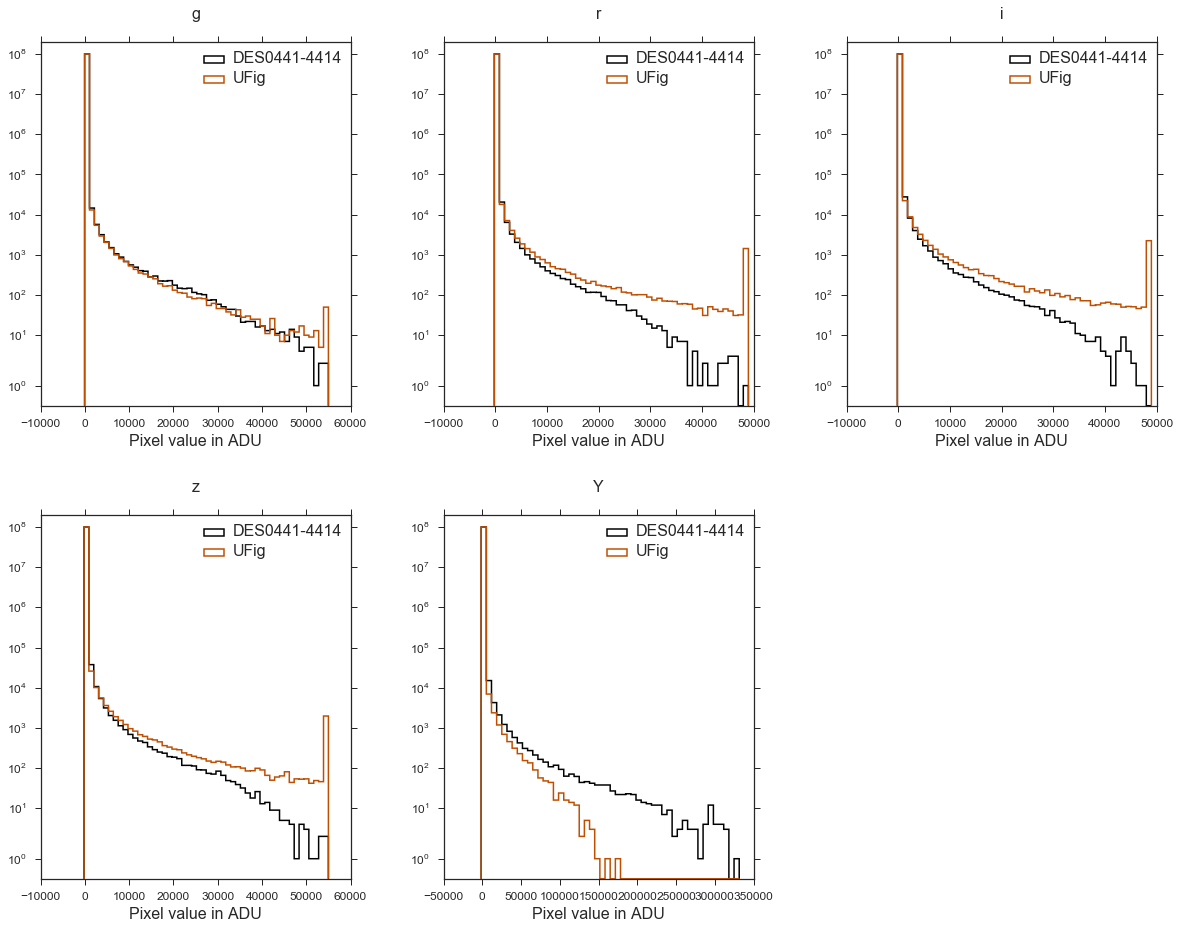

In [6]:
tile_diagnostics.pixel_histograms([paths_des_im, paths_ufig_im],
                                  fig_kwargs=dict(n_col=3, 
                                                  gridspec_kw=dict(wspace=0.3, hspace=0.3), 
                                                  figsize=(20, 15)),
                                  pixel_hist_kwargs=dict(labels=('DES0441-4414', 'UFig'), 
                                                         colors=('black', sns.xkcd_rgb['burnt orange'])),
                                  adjust_axes_kwargs=dict(label_fontsize=16, 
                                                          tick_fontsize=12));

# Magnitude counts

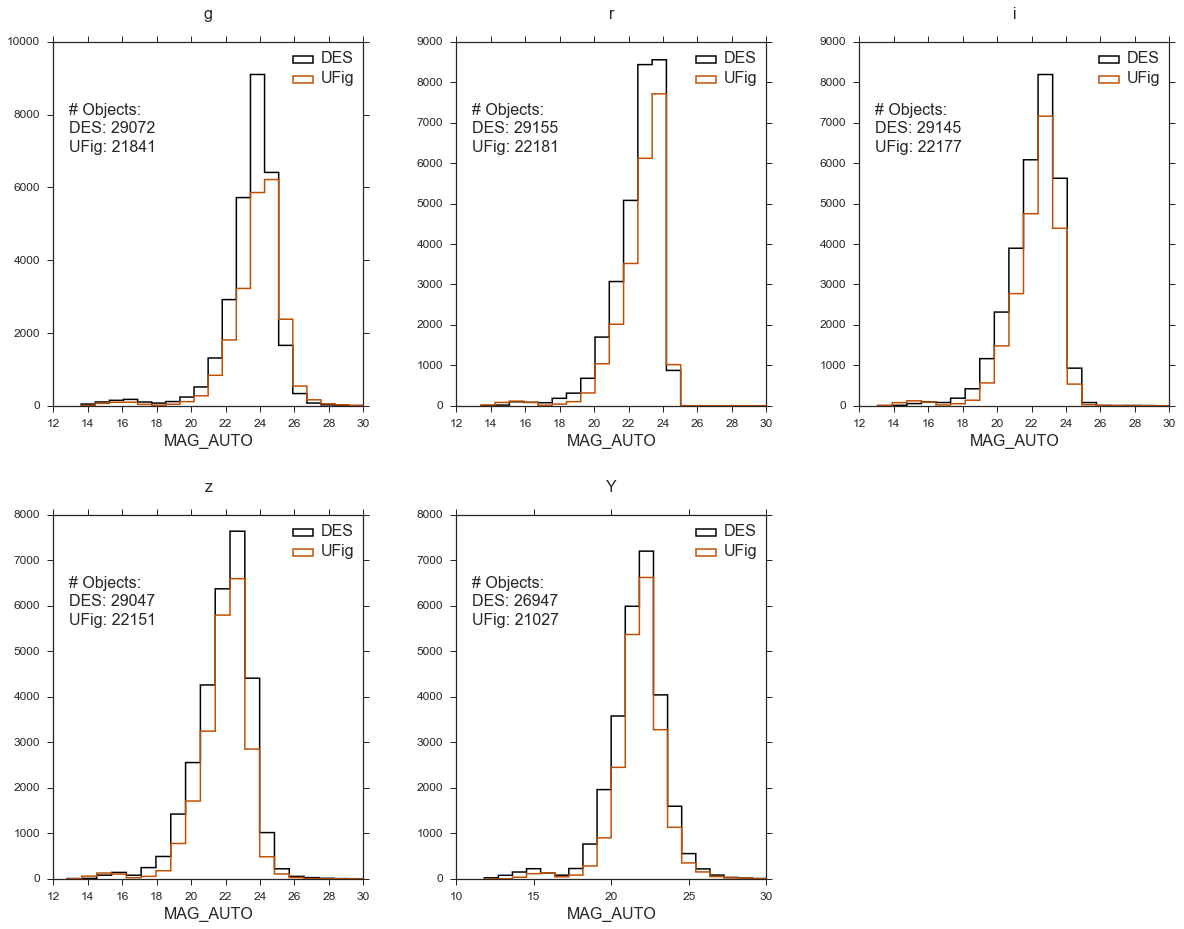

In [7]:
tile_diagnostics.df_histograms([des_mags, ufig_mags], 
                               ('DES', 'UFig'),
                               max_bound=30,
                               colors=('black', sns.xkcd_rgb['burnt orange']),
                               display_counts=True,
                               fig_kwargs=dict(n_col=3, 
                                               gridspec_kw=dict(wspace=0.3, hspace=0.3), 
                                               figsize=(20, 15)),
                               adjust_axes_kwargs=dict(xlabel='MAG_AUTO',
                                                       label_fontsize=16, 
                                                       tick_fontsize=12));

# $n(z)$

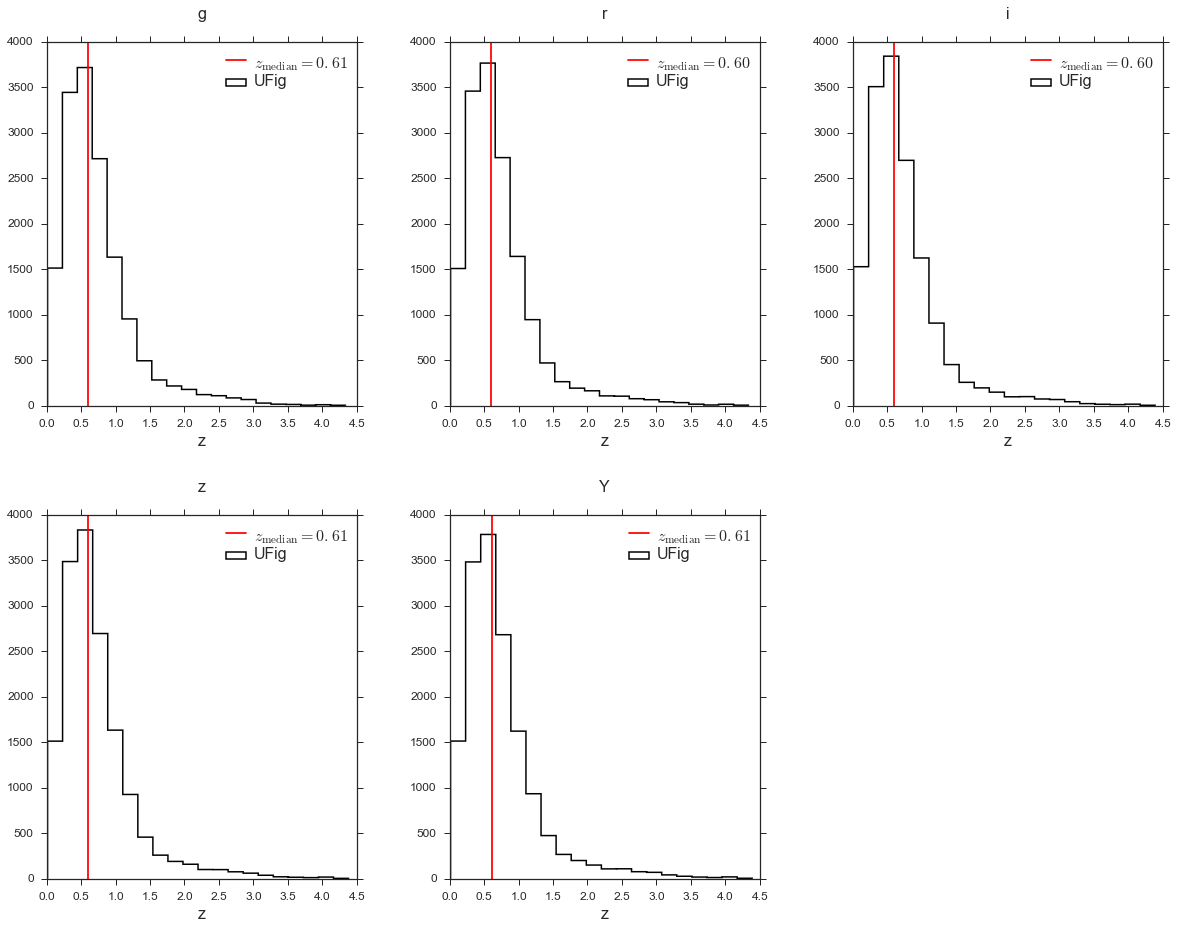

In [8]:
ax = tile_diagnostics.df_histograms([ufig_z],
                                    ('UFig',), 
                                    colors=('black',), 
                                    fig_kwargs=dict(n_col=3, 
                                                    gridspec_kw=dict(wspace=0.3, hspace=0.3), 
                                                    figsize=(20, 15)), 
                                    adjust_axes_kwargs=dict(xlabel='z', 
                                                            label_fontsize=16, 
                                                            tick_fontsize=12))[1]
ax_iter = np.ndenumerate(ax)

for f in config.filters:
    z_med = np.median(ufig_z[f])
    a = ax_iter.next()[1]
    a.axvline(z_med, color='red', label='$z_\mathrm{{median}} = {:.2f}$'.format(z_med))
    a.legend()
    
utils.adjust_axes(ax, xlabel='z', label_fontsize=16, tick_fontsize=12)

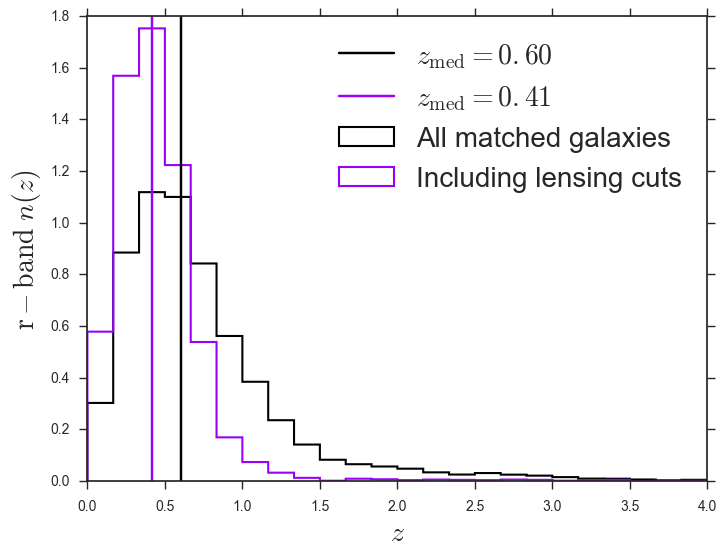

In [7]:
bins = np.linspace(0, 4, num=25)

plt.figure(figsize=(8, 6))

plt.hist(ufig_z['r'], bins=bins, normed=True, histtype='step', linewidth=1.5, color='black', 
         label='All matched galaxies')
plt.hist(lensing_z, bins=bins, normed=True, histtype='step', linewidth=1.5, color=sns.xkcd_rgb['vivid purple'], 
         label='Including lensing cuts')

med_ufig = np.median(ufig_z['r'])
med_lensing = np.median(lensing_z)
plt.axvline(x=med_ufig, color='black', label='$z_\mathrm{{med}} = {:.2f}$'.format(med_ufig))
plt.axvline(x=med_lensing, color=sns.xkcd_rgb['vivid purple'], label='$z_\mathrm{{med}} = {:.2f}$'.format(med_lensing))

plt.xlabel('$z$', fontsize=20)
plt.ylabel('$\mathrm{r-band} \ n(z)$', fontsize=20)
plt.legend(fontsize=20);

# Magnitude-size

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/joergherbel/python_packages/plot_util/plot_util/tile_diagnostics.py:359: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xHist1 = np.arange((len(yBins) - 1) * math.ceil((float)(xMax - xMin) / 2)).reshape(len(yBins) - 1, math.ceil((float)(xMax - xMin) / 2))
/Users/joergherbel/python_packages/plot_util/plot_util/tile_diagnostics.py:360: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xHist2 = np.arange((len(yBins) - 1) * math.ceil((float)(xMax - xMin) / 2)).reshape(len(yBins) - 1, math.ceil((float)(xMax - xMin) / 2))
/Users/joergherbel/python_packages/plot_util/plot_util/tile_diagnostics.py

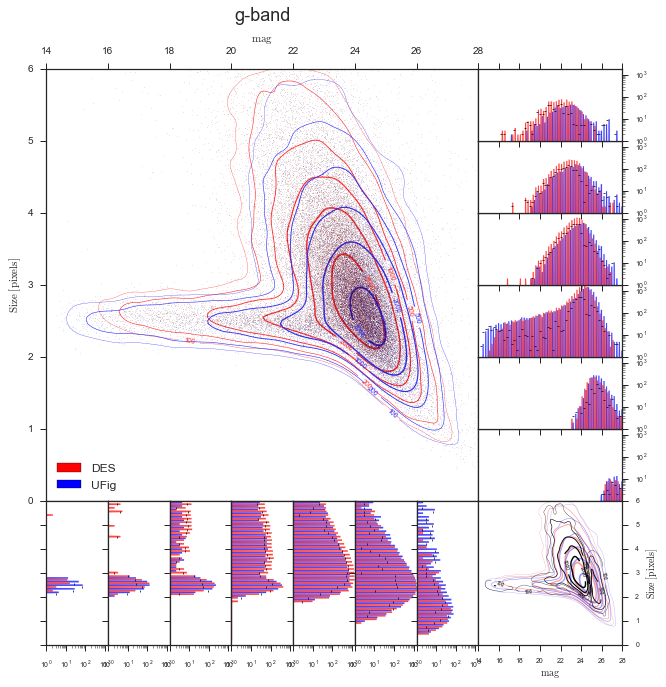

In [10]:
band = 'g'
tile_diagnostics.mag_size_plot(os.path.join(path_des, config.tile_name+'_{}_forced_photo.sexcat'.format(band)), 
                               os.path.join(path_ufig, config.tile_name+'_{}_forced_photo.sexcat'.format(band)), 
                               'DES', 
                               'UFig', 
                               title='{}-band'.format(band), figsize=(10, 10));

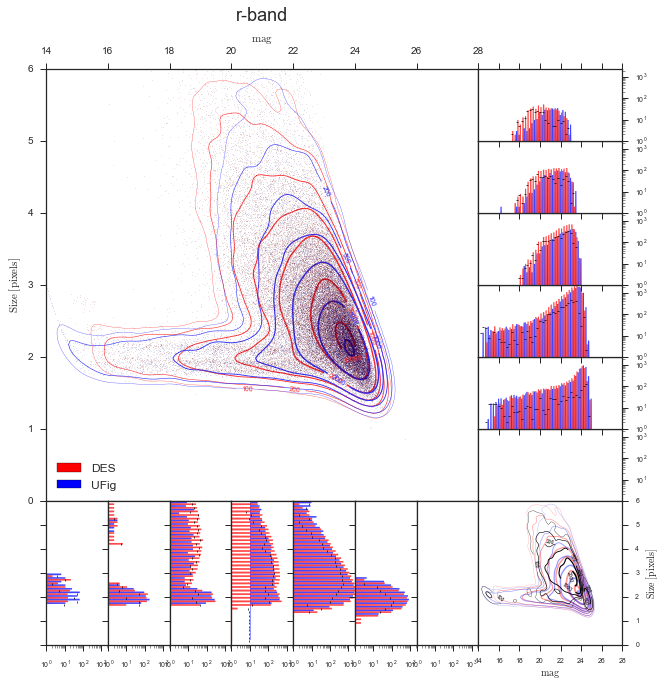

In [11]:
band = 'r'
tile_diagnostics.mag_size_plot(os.path.join(path_des, config.tile_name+'_{}_forced_photo.sexcat'.format(band)), 
                               os.path.join(path_ufig, config.tile_name+'_{}_forced_photo.sexcat'.format(band)), 
                               'DES', 
                               'UFig', 
                               title='{}-band'.format(band), figsize=(10, 10));

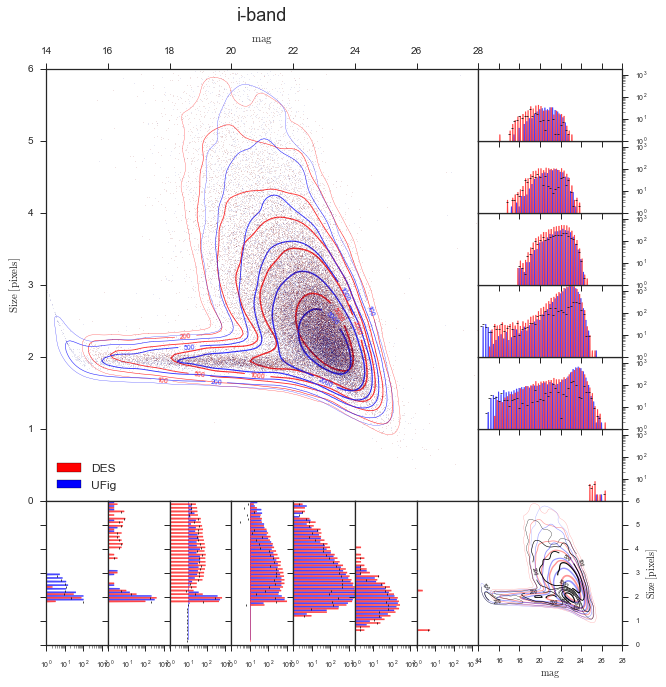

In [12]:
band = 'i'
tile_diagnostics.mag_size_plot(os.path.join(path_des, config.tile_name+'_{}_forced_photo.sexcat'.format(band)), 
                               os.path.join(path_ufig, config.tile_name+'_{}_forced_photo.sexcat'.format(band)), 
                               'DES', 
                               'UFig', 
                               title='{}-band'.format(band), figsize=(10, 10));

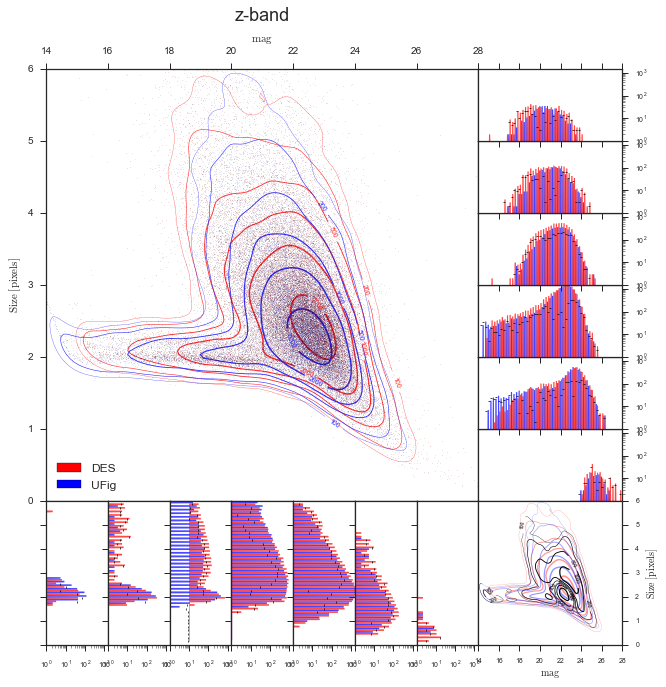

In [13]:
band = 'z'
tile_diagnostics.mag_size_plot(os.path.join(path_des, config.tile_name+'_{}_forced_photo.sexcat'.format(band)), 
                               os.path.join(path_ufig, config.tile_name+'_{}_forced_photo.sexcat'.format(band)), 
                               'DES', 
                               'UFig', 
                               title='{}-band'.format(band), figsize=(10, 10));

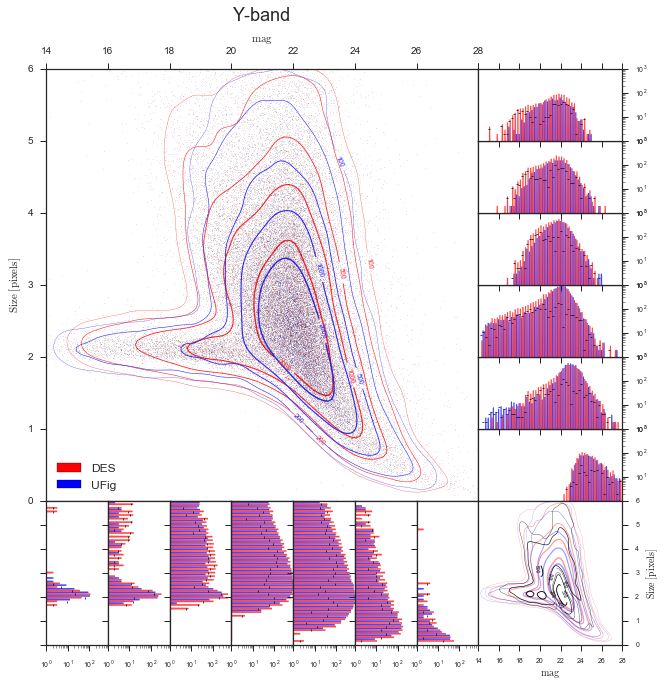

In [14]:
band = 'Y'
tile_diagnostics.mag_size_plot(os.path.join(path_des, config.tile_name+'_{}_forced_photo.sexcat'.format(band)), 
                               os.path.join(path_ufig, config.tile_name+'_{}_forced_photo.sexcat'.format(band)), 
                               'DES', 
                               'UFig', 
                               title='{}-band'.format(band), figsize=(10, 10));

# Inter-band correlations

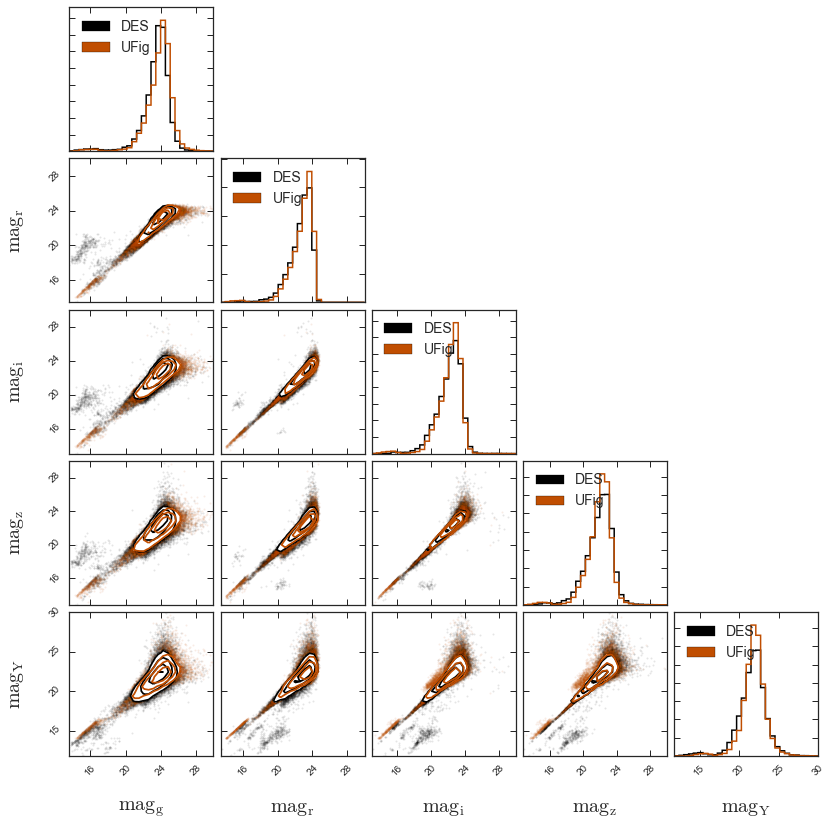

In [15]:
corner_plot_multi_data((des_mags, ufig_mags), 
                       30,
                       max_bound=30, 
                       colors=('black', sns.xkcd_rgb['burnt orange']), 
                       hist_kwargs={'normed': True, 'linewidth': 1.5}, 
                       hist2d_kwargs={'plot_density': False}, 
                       legend_labels=['DES', 'UFig'], 
                       legend_kwargs={'loc': 'upper left', 'fontsize': 14}, 
                       axes_labels=['$\mathrm{{mag}}_\mathrm{{{}}}$'.format(f) for f in config.filters], 
                       axes_labels_kwargs={'fontsize': 20});

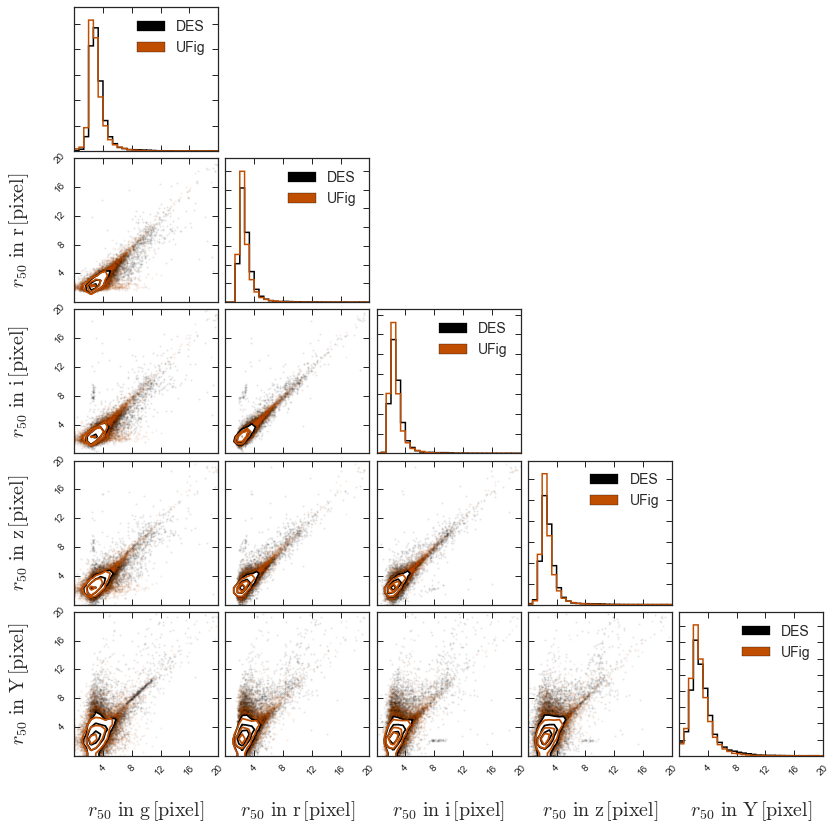

In [16]:
corner_plot_multi_data((des_r50, ufig_r50), 
                       30, 
                       min_bound=0, 
                       max_bound=20, 
                       colors=('black', sns.xkcd_rgb['burnt orange']), 
                       hist_kwargs={'normed': True, 'linewidth': 1.5}, hist2d_kwargs={'plot_density': False}, 
                       legend_labels=['DES', 'UFig'], legend_kwargs={'loc': 'upper right', 'fontsize': 14}, 
                       axes_labels=['$r_{{50}} \ \mathrm{{in \ {} \, [pixel]}}$'.format(f) for f in config.filters], 
                       axes_labels_kwargs={'fontsize': 20});

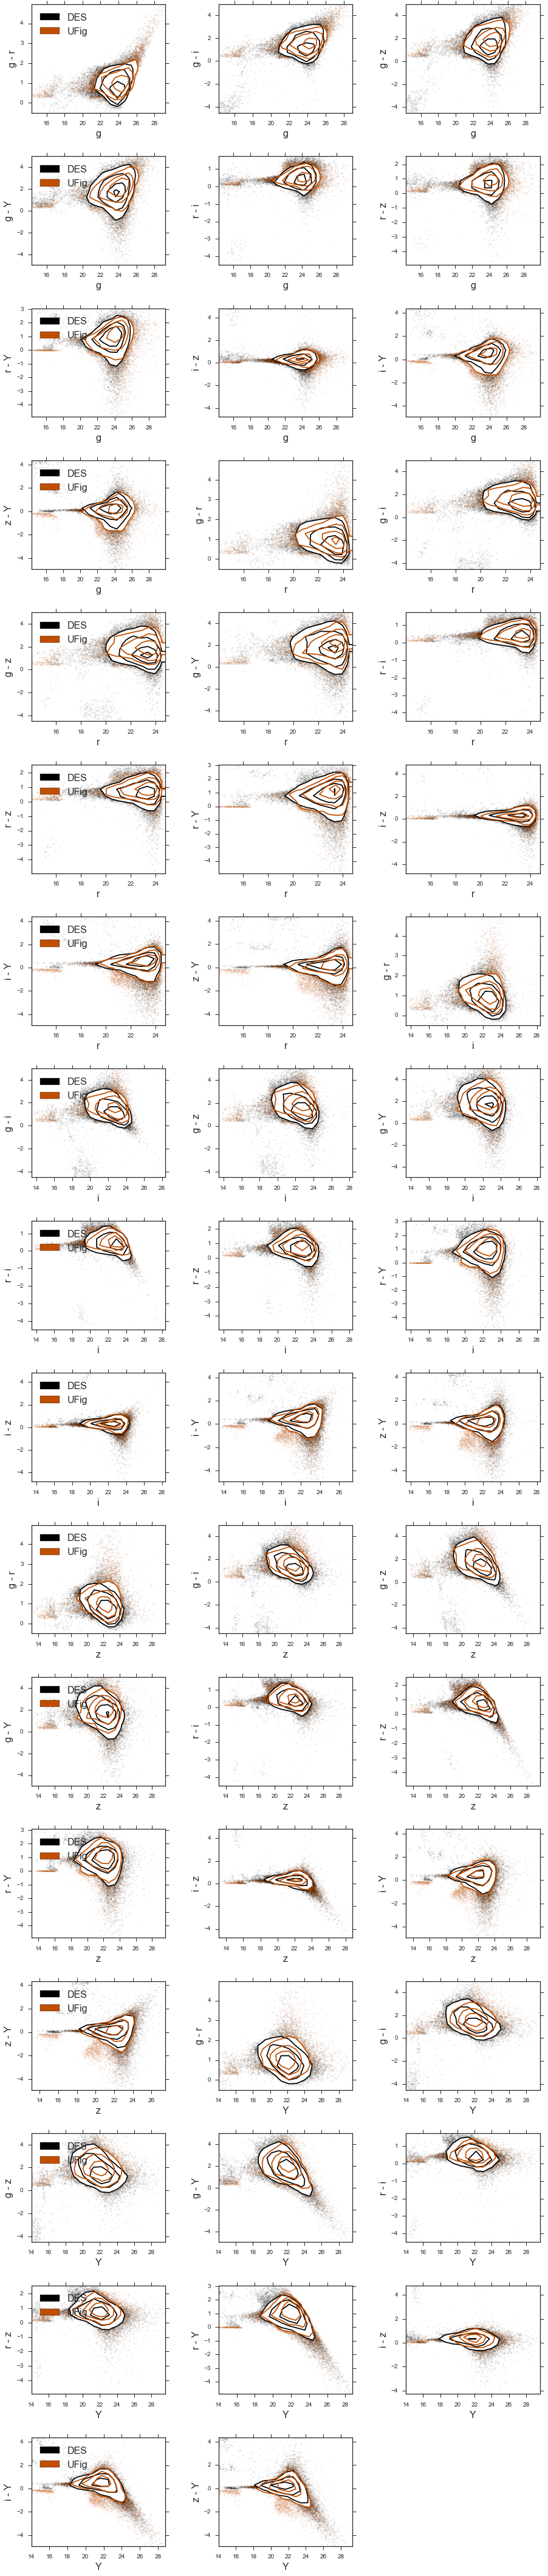

In [17]:
tile_diagnostics.mag_color_plots(config.filters, 
                                 [des_mags, ufig_mags], 
                                 20, 
                                 (-np.inf, 30), 
                                 (-5, 5), 
                                 ['DES', 'UFig'], (15, 75), 
                                 plot_colors=['black', sns.xkcd_rgb['burnt orange']],
                                 wspace=0.4, 
                                 hspace=0.4)

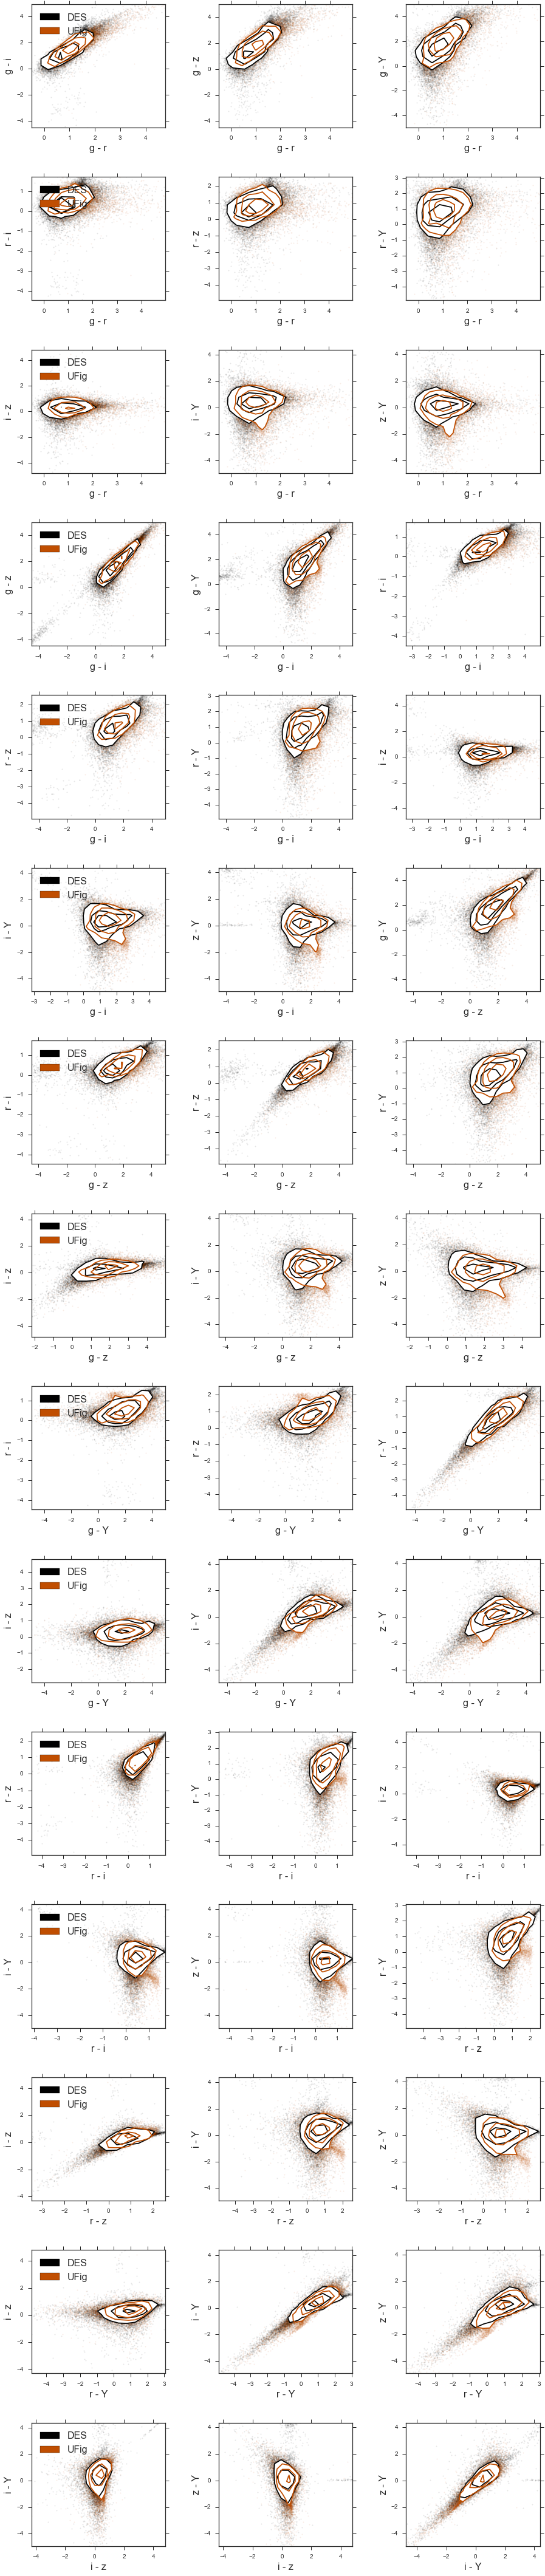

In [18]:
tile_diagnostics.color_color_plots(config.filters, 
                                   [des_mags, ufig_mags], 
                                   20, 
                                   (-5, 5), 
                                   ['DES', 'UFig'], 
                                   (15, 75), 
                                   plot_colors=['black', sns.xkcd_rgb['burnt orange']], 
                                   wspace=0.4, 
                                   hspace=0.4)